In [1]:
%reload_ext autoreload
%autoreload 1
%aimport experiment
%aimport utils
%aimport models.xai_models
%aimport helper

import pandas as pd
import numpy as np
from experiment import Experiment
import utils
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
import ecg_processing
from models.inception1d import Inception1d
from models.xai_models import *
import helper

In [2]:
# torch.set_default_device('cuda')

In [3]:
data_folder = '../data/ptbxl/'
output_folder = '../output/'
weights_path = '../output/exp1.1.1/models/fastai_inception1d/models/fastai_inception1d.pth'
sampling_frequency = 100

test_fold = 10
val_fold = 9
train_fold = 8

# models = [
#     conf_fastai_xresnet1d101,
#     conf_fastai_inception1d
# ]

experiments = [
	# ('exp0', 'all'),                    # raw SCP codes
	# ('exp1', 'diagnostic'),             # diagnostic SCP codes only
	# ('exp1.1', 'subdiagnostic'),        # diagnostic subclass of SCP codes
	('exp1.1.1', 'superdiagnostic'),    # diagnostic superclass of SCP codes
	# ('exp2', 'form'),                   # form-related SCP codes
	# ('exp3', 'rhythm')                  # rhythm-related SCP codes
	]

name, task = experiments[0]

In [4]:
state_dict = get_state_dict('exp1.1.1', 'fastai_inception1d')

In [ ]:
# Initialize the model and load the trained weights
model = Inception1d(
	num_classes=5,
	input_channels=12,
	use_residual=True,
	ps_head=0.5,
	lin_ftrs_head=[128],
	kernel_size=40
	)

model.load_state_dict(state_dict)
model.eval()
print(model)

Inception1d(
  (layers): Sequential(
    (0): InceptionBackbone(
      (im): ModuleList(
        (0): InceptionBlock1d(
          (bottleneck): Conv1d(12, 32, kernel_size=(1,), stride=(1,), bias=False)
          (convs): ModuleList(
            (0): Conv1d(32, 32, kernel_size=(39,), stride=(1,), padding=(19,), bias=False)
            (1): Conv1d(32, 32, kernel_size=(19,), stride=(1,), padding=(9,), bias=False)
            (2): Conv1d(32, 32, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)
          )
          (conv_bottle): Sequential(
            (0): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
            (1): Conv1d(12, 32, kernel_size=(1,), stride=(1,), bias=False)
          )
          (bn_relu): Sequential(
            (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): ReLU()
          )
        )
        (1-5): 5 x InceptionBlock1d(
          (bottleneck): Conv1d(128, 32, kernel_size=(1,

In [6]:
from torchsummary import summary
summary(model, input_size=(12,1000), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 32, 1000]             384
            Conv1d-2             [-1, 32, 1000]          39,936
            Conv1d-3             [-1, 32, 1000]          19,456
            Conv1d-4             [-1, 32, 1000]           9,216
         MaxPool1d-5             [-1, 12, 1000]               0
            Conv1d-6             [-1, 32, 1000]             384
       BatchNorm1d-7            [-1, 128, 1000]             256
              ReLU-8            [-1, 128, 1000]               0
  InceptionBlock1d-9            [-1, 128, 1000]               0
           Conv1d-10             [-1, 32, 1000]           4,096
           Conv1d-11             [-1, 32, 1000]          39,936
           Conv1d-12             [-1, 32, 1000]          19,456
           Conv1d-13             [-1, 32, 1000]           9,216
        MaxPool1d-14            [-1, 12

In [7]:
def predict(model, X):
	preds = model(X)
	return preds

In [8]:
# Load the dataset into variables data (signals) and Y (labels)
data, labels = utils.load_dataset(data_folder, sampling_frequency)
print("Computing labels")
labels = utils.compute_label_aggregations(labels, data_folder, task)
labels_col = task if task != 'all' else 'all_scp'
print("Selecting data")
data, labels, Y, _ = utils.select_data(data, labels, task, min_samples=0, outputfolder=f'{output_folder}/{name}/data')
input_shape = data[0].shape

Loading dataset
Dataset loaded
Computing labels
Selecting data
['CD' 'HYP' 'MI' 'NORM' 'STTC']


In [9]:
X_test = data	[labels.strat_fold == test_fold]
y_test = Y		[labels.strat_fold == test_fold]

In [10]:
# Load standardscaler object for preprocessing
with open(f'{output_folder}/{name}/data/standard_scaler.pkl', 'rb') as f:
	scaler = pickle.load(f)

# Load multilabelbinarizer object to get labels
with open(f'{output_folder}/{name}/data/mlb.pkl', 'rb') as f:
	mlb = pickle.load(f)

In [11]:
classes = mlb.classes_
print(classes)

['CD' 'HYP' 'MI' 'NORM' 'STTC']


In [12]:
def get_label_names(multihot_arr):
	c = mlb.classes_
	l = []
	for i in range(len(multihot_arr)):
		if multihot_arr[i] == 1:
			l.append(c[i])
	return l

In [14]:
# Choose some data
ids = [40, 100, 101]
x = X_test[ids]
y = y_test[ids]
print(x.shape, y.shape)

for label in y:
    print(get_label_names(label))
# for rec in x:
#     ecg_processing.plot_ecg_record(rec)
x_processed = utils.apply_standardizer(x, scaler)
x_processed = helper.transform_input(x_processed)

(3, 1000, 12) (3, 5)
['HYP', 'MI', 'STTC']
['CD']
['NORM']


In [15]:
preds = predict(model, x_processed)
probs = torch.sigmoid(preds)
print(preds)
print(probs)

tensor([[ -5.7375,  -0.6579,  11.3225, -10.1290,  -5.6736],
        [  4.1290,  -5.7556,  -3.7668,  -2.6489,  -3.1189],
        [ -5.9645,  -2.3800,  -2.4067,  -0.5112,  -0.2717]],
       grad_fn=<AddmmBackward0>)
tensor([[3.2124e-03, 3.4122e-01, 9.9999e-01, 3.9904e-05, 3.4236e-03],
        [9.8416e-01, 3.1551e-03, 2.2604e-02, 6.6059e-02, 4.2333e-02],
        [2.5617e-03, 8.4714e-02, 8.2663e-02, 3.7492e-01, 4.3250e-01]],
       grad_fn=<SigmoidBackward0>)


In [16]:
backbone = model.layers[0]
test = backbone(helper.transform_input(x))
print(test.shape)

torch.Size([3, 128, 1000])


In [17]:
modmodel = Inception1dMod(name)
modmodel.eval()

Inception1dMod(
  (inception): Inception1d(
    (layers): Sequential(
      (0): InceptionBackbone(
        (im): ModuleList(
          (0): InceptionBlock1d(
            (bottleneck): Conv1d(12, 32, kernel_size=(1,), stride=(1,), bias=False)
            (convs): ModuleList(
              (0): Conv1d(32, 32, kernel_size=(39,), stride=(1,), padding=(19,), bias=False)
              (1): Conv1d(32, 32, kernel_size=(19,), stride=(1,), padding=(9,), bias=False)
              (2): Conv1d(32, 32, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)
            )
            (conv_bottle): Sequential(
              (0): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
              (1): Conv1d(12, 32, kernel_size=(1,), stride=(1,), bias=False)
            )
            (bn_relu): Sequential(
              (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (1): ReLU()
            )
          )
          (1-5): 5 x In

In [18]:
def get_top_preds(model, x):
	pred = predict(model, x)
	_, indices = torch.sort(pred, descending=True)
	confidence = torch.sigmoid(pred) * 100
	for i in range(indices.shape[0]):
		for idx in indices[i]:
			print(f'{classes[idx]} {idx.data} {confidence[i,idx].item():.3f}', end='\t| ')
		print()
	return pred

In [19]:
pred = get_top_preds(modmodel, x_processed)

for label in y:
	print(get_label_names(label))

MI 2 99.999	| HYP 1 34.122	| STTC 4 0.342	| CD 0 0.321	| NORM 3 0.004	| 
CD 0 98.416	| NORM 3 6.606	| STTC 4 4.233	| MI 2 2.260	| HYP 1 0.316	| 
STTC 4 43.250	| NORM 3 37.492	| HYP 1 8.471	| MI 2 8.266	| CD 0 0.256	| 
['HYP', 'MI', 'STTC']
['CD']
['NORM']


In [20]:
# Choose some more data
ids = [40, 100, 101]
x = X_test[ids]
y = y_test[ids]
print(x.shape, y.shape)

# for label in y:
#     print(get_label_names(label))
# for rec in x:
#     ecg_processing.plot_ecg_record(rec)
x_processed = utils.apply_standardizer(x, scaler)
x_processed = helper.transform_input(x_processed)

(3, 1000, 12) (3, 5)


In [21]:
pred = get_top_preds(modmodel, x_processed)

for label in y:
	print(get_label_names(label))

MI 2 99.999	| HYP 1 34.122	| STTC 4 0.342	| CD 0 0.321	| NORM 3 0.004	| 
CD 0 98.416	| NORM 3 6.606	| STTC 4 4.233	| MI 2 2.260	| HYP 1 0.316	| 
STTC 4 43.250	| NORM 3 37.492	| HYP 1 8.471	| MI 2 8.266	| CD 0 0.256	| 
['HYP', 'MI', 'STTC']
['CD']
['NORM']


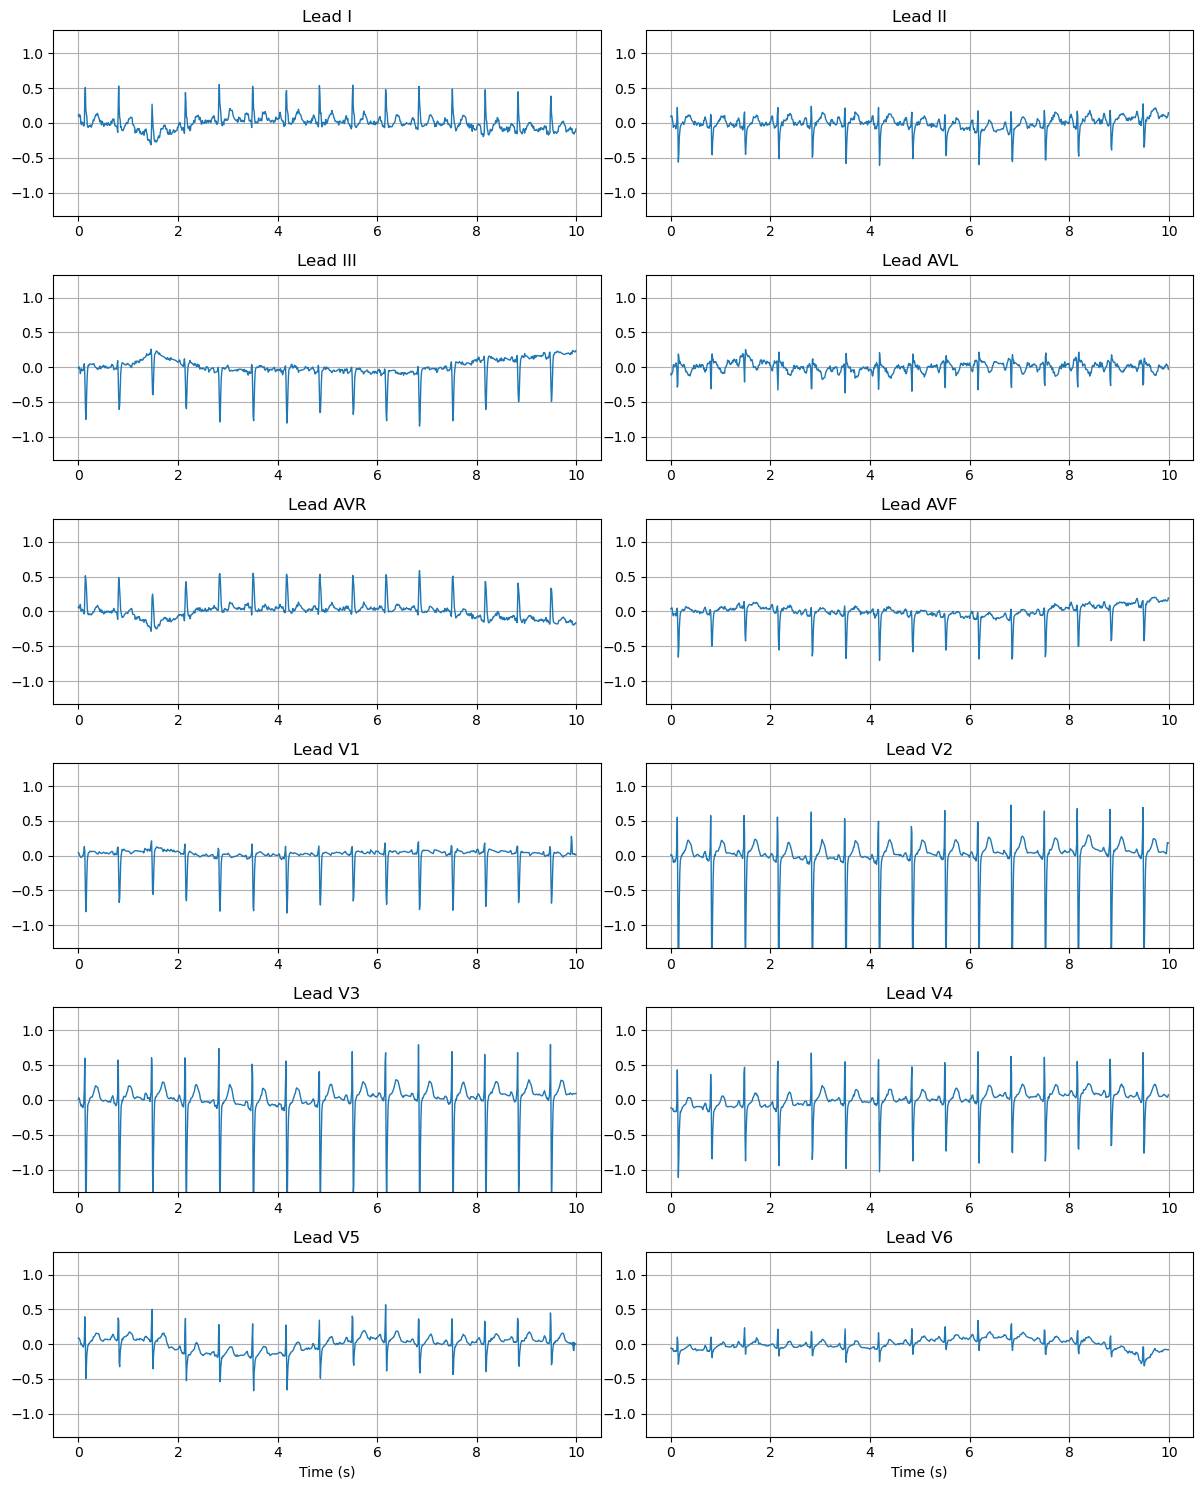

In [22]:
ecg_processing.plot_ecg_record(x[1])

In [23]:
print(pred)

tensor([[ -5.7375,  -0.6579,  11.3225, -10.1290,  -5.6736],
        [  4.1290,  -5.7556,  -3.7668,  -2.6489,  -3.1189],
        [ -5.9645,  -2.3800,  -2.4067,  -0.5112,  -0.2717]],
       grad_fn=<AddmmBackward0>)


In [24]:
check_class = 3
check_ecg = 2

In [26]:
# move both models to cuda
model = model.cuda()
modmodel = modmodel.cuda()
# also move x_processed to cuda
x_processed_cuda = x_processed.cuda()

In [27]:
pred = get_top_preds(modmodel, x_processed_cuda)
gradcam = get_cam(pred[check_ecg], modmodel, x_processed_cuda[check_ecg].unsqueeze(0), check_class)
print(y)

/home/iyafath/anaconda3/envs/ecg_env/lib/python3.8/site-packages/torch/nn/modules/conv.py:309: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343998658/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv1d(input, weight, bias, self.stride,


MI 2 99.999	| HYP 1 34.122	| STTC 4 0.342	| CD 0 0.321	| NORM 3 0.004	| 
CD 0 98.416	| NORM 3 6.606	| STTC 4 4.233	| MI 2 2.260	| HYP 1 0.316	| 
STTC 4 43.250	| NORM 3 37.492	| HYP 1 8.471	| MI 2 8.266	| CD 0 0.256	| 
[[0 1 1 0 1]
 [1 0 0 0 0]
 [0 0 0 1 0]]


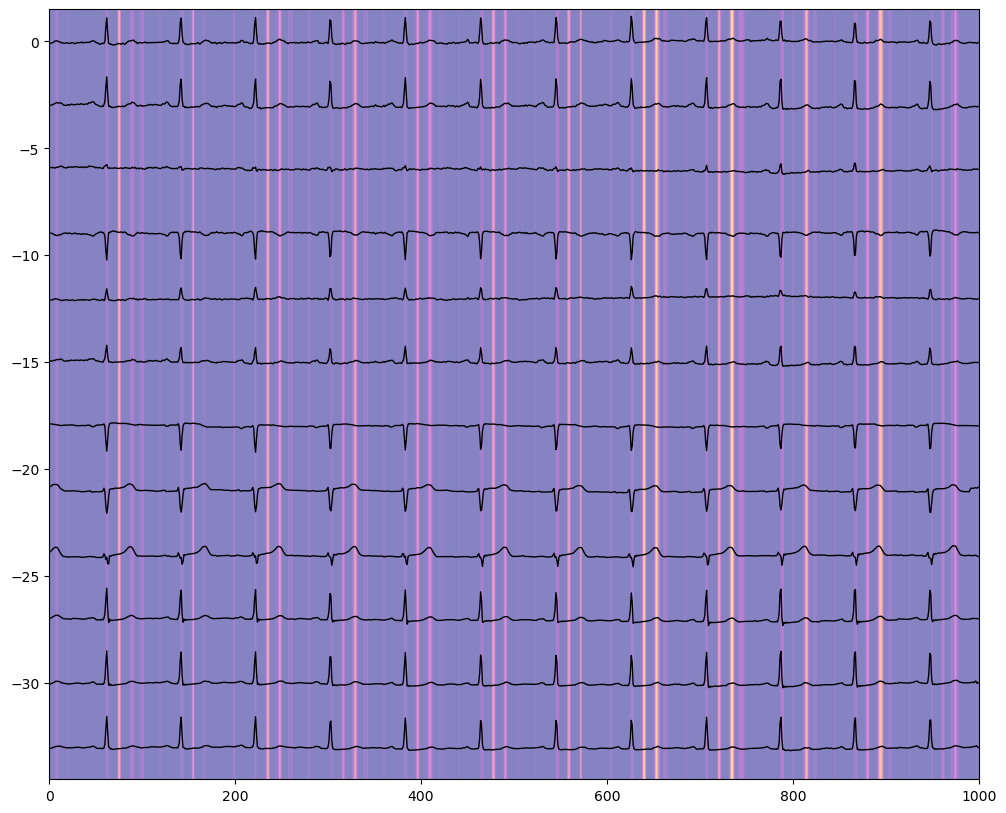

In [28]:
ecg_processing.plot_ecg_heatmap(x[check_ecg], gradcam)

In [30]:
print("Measuring execution time for regular model")
torch.cuda.empty_cache()
_, _ = helper.benchmark(predict, model=model, runs=50, X=x_processed_cuda)
torch.cuda.empty_cache()
print("Measuring execution time for Grad-CAM model")
_, _ = helper.benchmark(predict, model=modmodel, runs=50, X=x_processed_cuda)

Measuring execution time for regular model
predict avg time over 50 runs: 0.044598 seconds
Measuring execution time for Grad-CAM model
predict avg time over 50 runs: 0.104401 seconds
